In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
import scipy.io.wavfile as wav
from glob import glob
import os
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils

def normalizeData(data):
    rows,_ = np.shape(data);
    for i in range(rows):
        row = data[i,:]
        norm = row - min(row)
        data[i,:] = norm / max(norm)
    return data

C:\Anaconda3\envs\tensorflow\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
Using TensorFlow backend.


## Split .wav files into single words

In [3]:
path_word=['otworz.wav', 'zamknij.wav','garaz.wav' 'zrob.wav', 'nastroj.wav', 'wlacz.wav', 'wylacz.wav', 'muzyke.wav', 'swiatlo.wav', 'zapal.wav', 'podnies.wav', 'rolety.wav', 'telewizor.wav']
folder = 'data/'
wordsFolder = folder + 'words/'

for f in glob(wordsFolder+'*'):
    os.remove(f)
    
index = 0
for file in glob(folder+'*.wav'):
    file_name = file[0:-4]      
    txt_file = open(file_name+'.txt',"r")
    file_content = txt_file.readlines()
    txt_file.close()
    for line in file_content:     
        single_word = line.split()
        start_time=float(single_word[0])*1000
        end_time=float(single_word[1])*1000

        newAudio = AudioSegment.from_wav(file_name+'.wav')
        newAudio = newAudio[start_time:end_time]
        newAudio.export(out_f=wordsFolder+single_word[2]+str(index).zfill(2)+'.wav', format='wav')
    index = index + 1

## Read words from .wav files

In [90]:
signals = []
classes = []

for f in listdir(wordsFolder):
    if isfile(join(wordsFolder, f)):
        _, signal = wav.read(wordsFolder + f)
        if(signal.ndim is 2): signal = np.sum(signal,axis=1)/2
        signals.append(signal)
        classes.append(f[:-6])

print(np.shape(signals))
print(np.shape(classes))

encoder = LabelEncoder()
encoder.fit(classes)
encodedClasses = encoder.transform(classes)
print(encodedClasses)

(624,)
(624,)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6 

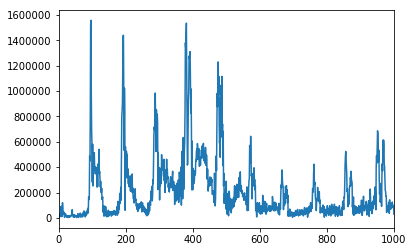

In [99]:
# Calculate FFT for every signal
from scipy.fftpack import fft

fouriers = []
N = 44100

for signal in signals:
    yf = fft(signal)
    spectrum = np.abs(yf[:N//2])
    fouriers.append(spectrum)

plt.plot(fouriers[0])
plt.xlim([0, 1000])
plt.show()

C:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract


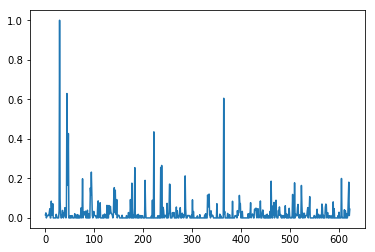

In [100]:
# Input/Output vector
parts = 30
numberOfParameters = 101
numberOfSignals = np.shape(signals)[0]
inputMatrix = np.empty((numberOfSignals, numberOfParameters))

for index in range(0, len(signals)):
    s = signals[index]
    f = fouriers[index]
    
    #biggestFreqs = np.argsort(-f)
    #biggestAmps = spectrum[biggestFreqs]

    inputMatrix[index, 0:parts] = [np.average(np.abs(s[i:int(i+np.ceil(len(s)/parts))])) for i in np.arange(0, len(s), np.ceil(len(s)/parts), dtype=np.int32)]
    inputMatrix[index, parts:2*parts] = [np.mean(s[i:int(i+np.ceil(len(s)/parts))]) for i in np.arange(0, len(s), np.ceil(len(s)/parts), dtype=np.int32)]
    inputMatrix[index, 2*parts:3*parts] = [np.max(f[i:int(i+np.ceil(len(f)/parts))]) for i in np.arange(0, len(f), np.ceil(len(f)/parts), dtype=np.int32)]
    inputMatrix[index, 3*parts] = np.ceil(len(s)/parts)
    inputMatrix[index, 3*parts:3*parts+10] = np.argsort(-f)[0:10]

inputMatrix = np.transpose(normalizeData(np.transpose(inputMatrix)))
inputMatrix = np.nan_to_num(inputMatrix)
inputMatrix[inputMatrix<0.01] = 0
output = np_utils.to_categorical(encodedClasses)

plt.plot(inputMatrix[:,0])
plt.show()

## Save words and classes into .csv files

In [108]:
np.savetxt("inputs.csv", inputMatrix, delimiter=",")
np.savetxt("outputs.csv", output, delimiter=",")

## Read words from .csv files

In [107]:
inputMatrix = np.genfromtxt('inputs.csv',delimiter=',')
output = np.genfromtxt('outputs.csv',delimiter=',')

[[0.01545686 0.02568892 0.02653842 ... 0.0172469  0.01662088 1.        ]
 [0.02558041 0.03105985 0.03301397 ... 0.         0.02216117 1.        ]
 [0.         0.         0.02142853 ... 0.         0.02138278 1.        ]
 ...
 [0.18071629 0.07161895 0.0597961  ... 0.01184867 0.01172161 1.        ]
 [0.01179859 0.05204267 0.02989958 ... 0.01509676 0.01501832 1.        ]
 [0.04416    0.04533035 0.03057404 ... 0.         0.         1.        ]]


In [6]:
# Split data to trainting and testing sets
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputMatrix, output, test_size=0.15)
print("x_train: %s\nx_test: %s\ny_train: %s\ny_test: %s" % (np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test)))

x_train: (530, 101)
x_test: (94, 101)
y_train: (530, 13)
y_test: (94, 13)


C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
# ANN
model = Sequential()
model.add(Dense(40, activation='relu', input_dim=numberOfParameters))
model.add(Dropout(0.5))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=600, verbose=0)

# Prediction
prediction = np.argmax(model.predict(x_test),axis=1)
y_test_classes = np.argmax(y_test, axis=1)
predictedCorrectly = np.sum([y_test_classes-prediction == 0])
print("Predicted: %s/%s (%0.3s%%)" % (predictedCorrectly, len(y_test_classes), 100*predictedCorrectly/len(y_test_classes)))

for index in range(0,len(prediction)):
    print(str(index) + ".\t" + encoder.inverse_transform(y_test_classes[index]) + "    \t\t" + encoder.inverse_transform(prediction[index]))

Predicted: 56/94 (59.%)
0.	ZAMKNIJ    		NASTROJ
1.	PODNIES    		ZAPAL
2.	MUZYKE    		MUZYKE
3.	ROLETY    		ZAMKNIJ
4.	PODNIES    		PODNIES
5.	WLACZ    		WYLACZ
6.	ZROB    		SWIATLO
7.	ZAMKNIJ    		SWIATLO
8.	NASTROJ    		SWIATLO
9.	ZAPAL    		ZAMKNIJ
10.	SWIATLO    		SWIATLO
11.	ZAMKNIJ    		ZAMKNIJ
12.	TELEWIZOR    		TELEWIZOR
13.	TELEWIZOR    		ZROB
14.	ROLETY    		WYLACZ
15.	ROLETY    		ROLETY
16.	OTWORZ    		ZAMKNIJ
17.	ZROB    		ZAMKNIJ
18.	PODNIES    		PODNIES
19.	TELEWIZOR    		TELEWIZOR
20.	NASTROJ    		ZAMKNIJ
21.	NASTROJ    		ZAMKNIJ
22.	MUZYKE    		ZAPAL
23.	SWIATLO    		SWIATLO
24.	ROLETY    		ROLETY
25.	OTWORZ    		OTWORZ
26.	ZAMKNIJ    		ZAMKNIJ
27.	WLACZ    		ROLETY
28.	TELEWIZOR    		TELEWIZOR
29.	ZAPAL    		ZAPAL
30.	GARAZ    		TELEWIZOR
31.	MUZYKE    		MUZYKE
32.	GARAZ    		GARAZ
33.	SWIATLO    		SWIATLO
34.	GARAZ    		ZROB
35.	WLACZ    		ZROB
36.	WLACZ    		WLACZ
37.	PODNIES    		PODNIES
38.	ZROB    		ZROB
39.	ROLETY    		ROLETY
40.	GARAZ    		WYLACZ
41.	PODNIES    	

C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Return